In [1]:
"""
Gather event- and daily-level FIRED polygons for western U.S. ecoregions
Author: maxwell.cook@colorado.edu
"""

import os, time, glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from shapely.geometry import box
from datetime import datetime
from rasterstats import zonal_stats

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready !")

Ready !


In [23]:
# Load the event FIRED polygons
fp = os.path.join(maindir,'FIRED/data/spatial/mod/events/fired-events_conus_ak_2000_to_2024_lambert.gpkg')
events = gpd.read_file(fp)
events = events[events['ig_year'] >= 2018] # work with 2018->
events = events.to_crs(proj) # project to EPSG:5070
# Load the western U.S. ecoregions
fp = os.path.join(projdir,'data/spatial/mod/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','geometry']]
ecol3 = ecol3.rename(columns={'NA_L3NAME': 'na_l3name'})

# Extract within western U.S. ecoregions (CONUS)
assert events.crs == ecol3.crs, "CRS mismatch, fix it !"
events_west = gpd.sjoin(events, ecol3, how='inner', predicate='within')
events_west.drop('index_right', axis=1, inplace=True)
    
print(f"There are {len(events_west)} unique fire events across western U.S. ecoregions in CONUS (2018-2024).")
print(f"Data columns:\n{events_west.columns}")

# Save the file.
events_west.to_file(os.path.join(projdir, 'data/spatial/raw/FIRED/fired-events_west_2018_to_2024.gpkg'))

del events, ecol3
gc.collect() # clean up

There are 9936 unique fire events across western U.S. ecoregions in CONUS.
Data columns:
Index(['id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mn_grw_px', 'mu_grw_px', 'mx_grw_km2', 'mn_grw_km2',
       'mu_grw_km2', 'mx_grw_dte', 'x', 'y', 'ig_utm_x', 'ig_utm_y', 'lc_code',
       'lc_mode', 'lc_name', 'lc_desc', 'lc_type', 'eco_mode', 'eco_name',
       'eco_type', 'tot_perim', 'geometry', 'na_l3name'],
      dtype='object')


0

In [27]:
fired_ids_west = set(events_west['id']) # unique fire ids
print(len(fired_ids_west))

# Extract the daily events from the western U.S. subset
fp = os.path.join(maindir,'FIRED/data/spatial/mod/events/fired-daily_conus_ak_2000_to_2024_lambert.gpkg')
daily = gpd.read_file(fp)
daily_west = daily[daily['id'].isin(fired_ids_west)]
print(f"There are [{len(daily_west)}] unique daily perimeters for western U.S. FIRED (2018-2024).")

# Save the file.
daily_west.to_file(os.path.join(projdir, 'data/spatial/raw/FIRED/fired-daily_west_2018_to_2024.gpkg'))

del daily
gc.collect() # clean up                   

9936
There are [32493] unique daily perimeters for western U.S. FIRED (2018-2024).


0

In [ ]:
# Make some plots !

In [ ]:
# Burned area by month/year

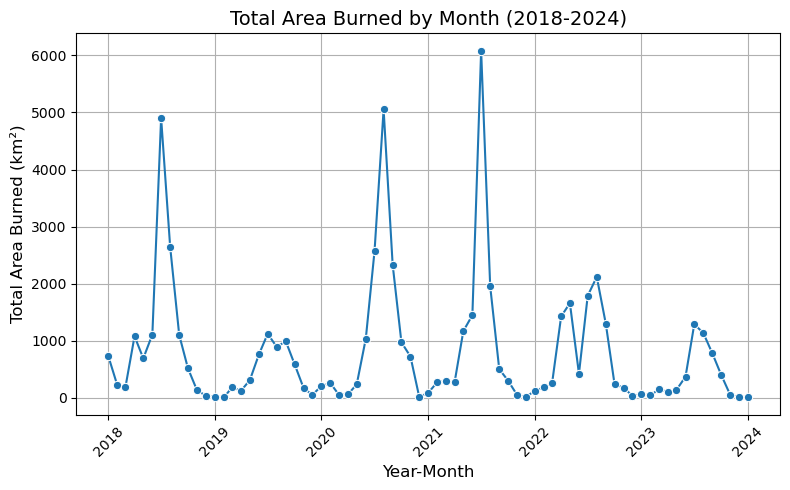

In [41]:
# Create a new column for 'year-month'
events_west['ig_date'] = pd.to_datetime(events_west['ig_date'])
events_west['year_month'] = events_west['ig_date'].dt.to_period('M')
# Aggregate the total area burned ('tot_ar_km2') by 'year_month'
monthly_area_burned = events_west.groupby('year_month')['tot_ar_km2'].sum().reset_index()
# Convert 'year_month' back to a datetime format for plotting
monthly_area_burned['year_month'] = monthly_area_burned['year_month'].dt.to_timestamp()

# Plotting the time-series
plt.figure(figsize=(8, 5))
sns.lineplot(x='year_month', y='tot_ar_km2', data=monthly_area_burned, marker='o')
plt.title('Total Area Burned by Month (2018-2024)', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Total Area Burned (km²)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

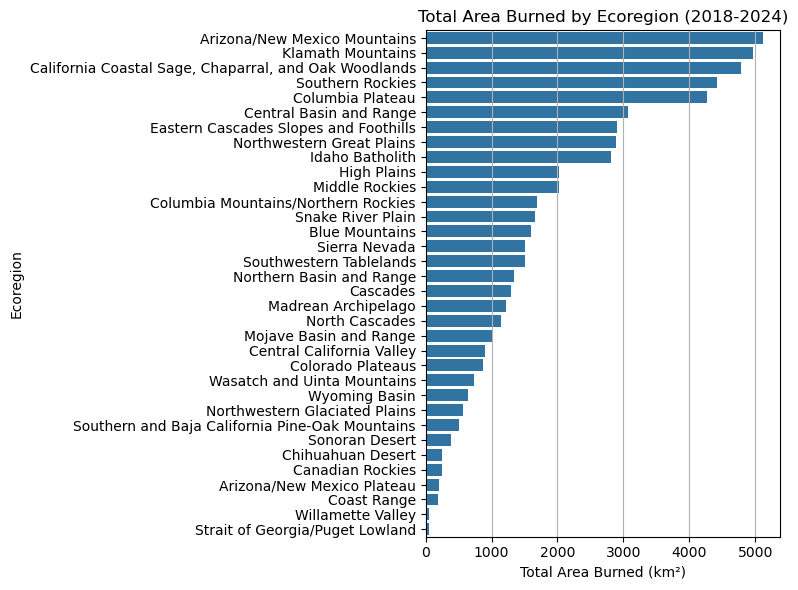

In [39]:
# Aggregate total burned area by ecoregion
eco_burned_area = events_west.groupby('na_l3name')['tot_ar_km2'].sum().reset_index()

# Sort the data by total burned area in descending order
eco_burned_area = eco_burned_area.sort_values(by='tot_ar_km2', ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='tot_ar_km2', y='na_l3name', data=eco_burned_area)
plt.title('Total Area Burned by Ecoregion (2018-2024)', fontsize=12)
plt.xlabel('Total Area Burned (km²)', fontsize=10)
plt.ylabel('Ecoregion', fontsize=10)
plt.grid(True, axis='x')
plt.tight_layout()

# Show the plot
plt.show()

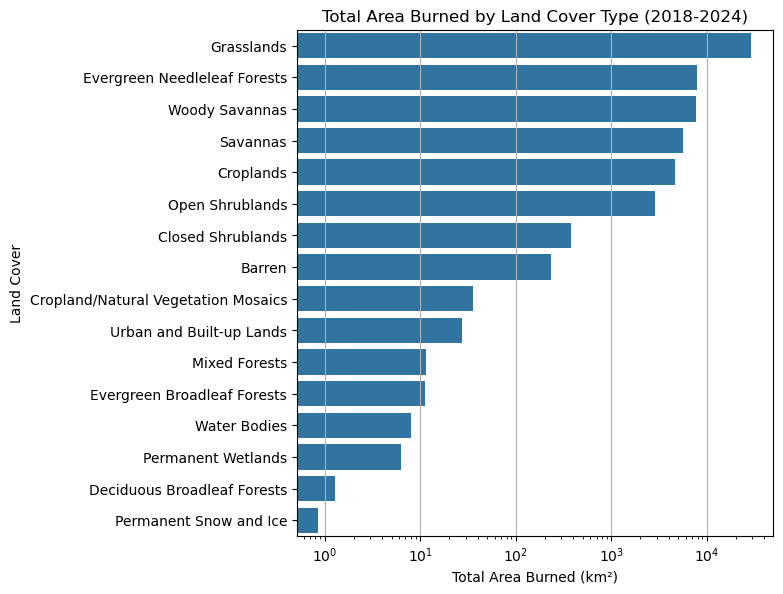

In [48]:
# Aggregate total burned area by ecoregion
lc_burned_area = events_west.groupby('lc_name')['tot_ar_km2'].sum().reset_index()
# Sort the data by total burned area in descending order
lc_burned_area = lc_burned_area.sort_values(by='tot_ar_km2', ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='tot_ar_km2', y='lc_name', data=lc_burned_area)
plt.title('Total Area Burned by Land Cover Type (2018-2024)', fontsize=12)
plt.xlabel('Total Area Burned (km²)', fontsize=10)
plt.ylabel('Land Cover', fontsize=10)
plt.grid(True, axis='x')
plt.tight_layout()

plt.xscale('log')

# Show the plot
plt.show()

In [49]:
gc.collect()

72157